In [96]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score

In [46]:
# Notebook params
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 15})

In [47]:
org_data = pd.read_csv('source/data.csv')

print('Dataset shape:',org_data.shape)
with pd.option_context('display.max_columns', None):
    display(org_data.head())

Dataset shape: (10000, 21)


,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,569520,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False,37.454012,1000.000000
1,750365,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True,95.071431,1333.333333
2,199901,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False,73.199394,916.666667
3,478866,16-25,male,majority,0-9y,university,low,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False,59.865848,916.666667
4,731664,26-39,male,majority,10-19y,none,low,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True,15.601864,1000.000000


### Exploratory Data Analysis

In [19]:
org_data.describe()

,id,credit_score,postal_code,annual_mileage,speeding_violations,DUIs,past_accidents,telematic_score,monthly_mileage
count,10000.000000,9018.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000,9043.000000
mean,500521.906800,0.515813,19864.548400,11697.003207,1.482900,0.23920,1.056300,49.415956,974.750267
std,290030.768758,0.137688,18915.613855,2818.434528,2.241966,0.55499,1.652454,28.763013,234.869544
min,101.000000,0.053358,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.001163,166.666667
25%,249638.500000,0.417191,10238.000000,10000.000000,0.000000,0.00000,0.000000,24.632887,833.333333
50%,501777.000000,0.525033,10238.000000,12000.000000,0.000000,0.00000,0.000000,49.252862,1000.000000
75%,753974.500000,0.618312,32765.000000,14000.000000,2.000000,0.00000,2.000000,74.000635,1166.666667
max,999976.000000,0.960819,92101.000000,22000.000000,22.000000,6.00000,15.000000,99.971767,1833.333333


In [4]:
# 1. What proportion of customers with a credit score below 0.2 made a claim in the last year?
small_credit = org_data[org_data.credit_score<0.2]
small_credit_claim = small_credit['outcome'].value_counts(normalize=True).to_frame().T[True][0]
print('{} percent of customers with a credit score below 0.2 made a claim last year'.format(round(small_credit_claim*100)))

60 percent of customers with a credit score below 0.2 made a claim last year


Text(0, 0.5, 'Number of cases')

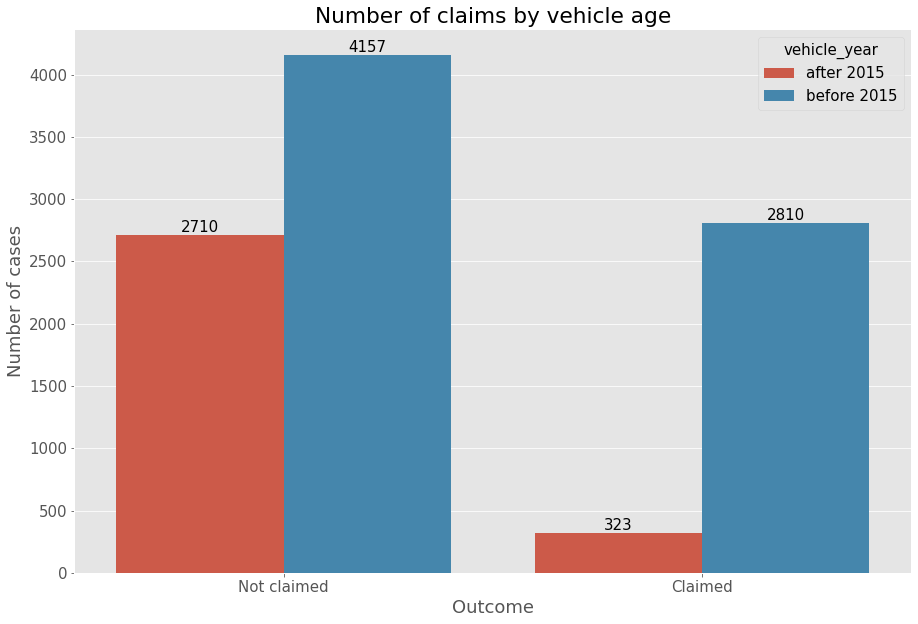

In [48]:
# Main points visualization
plt.rcParams["figure.figsize"] = (15,10)

org_data['Outcome'] = np.where(org_data['outcome'], 'Claimed', 'Not claimed')
ax = sns.countplot(data=org_data, x='Outcome', hue='vehicle_year')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by vehicle age')
plt.xlabel('Outcome')
plt.ylabel('Number of cases')

The plot presents number of claims made and not by available vehicle age.

For over 40% of vehicles older than 2015 a claim has been made. In the case of younger vehicles this is just ~10%. This could be due to various reasons, like worse equipment on the older cars. Younger vehicles have overall better systems, like traction control or special sensors for keeping a car in line. As the risk of making a claim is significantly higher for the older vehicles, their premiums should be higher as well.

Text(0, 0.5, 'Number of cases')

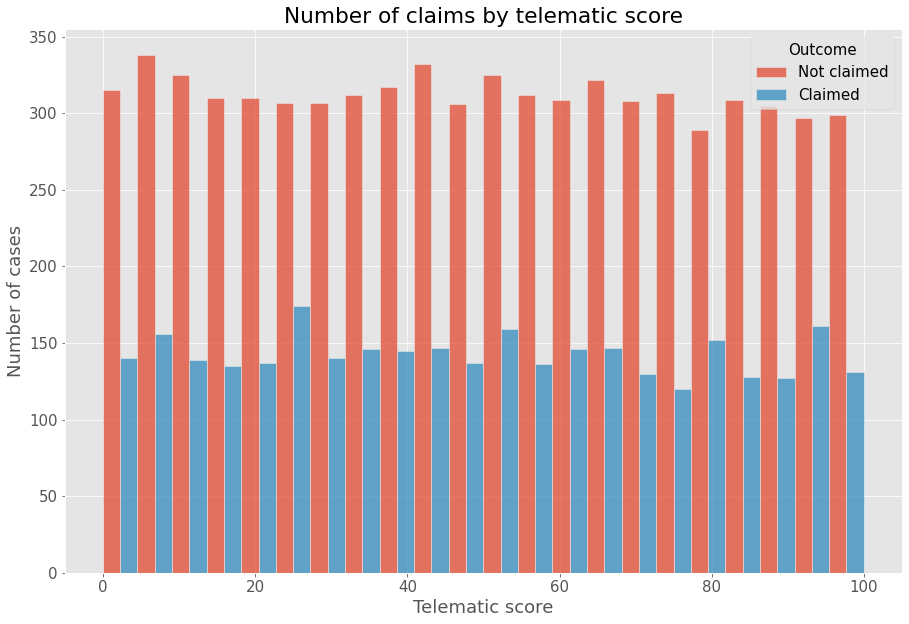

In [65]:
ax = sns.histplot(data=org_data, x='telematic_score', hue='Outcome',multiple='dodge')

plt.title('Number of claims by telematic score')
plt.xlabel('Telematic score')
plt.ylabel('Number of cases')

Interestingly, the telematic score does not seem to have any effect on the claims. For vast majority of scores the claims oscillate around 30% of all cases. That would suggest, that the driving style does not impact the accidents. This seems counter-intuitive, but it can be explained. One possibility would be malfunctioning or bad telematics devices. If that is the case, the algorithm in these devices should be adjusted or replaced. Second possibility is the randomization of provided data, in which case it is not possible to say more until more records are provided.  

Text(0, 0.5, 'Number of cases')

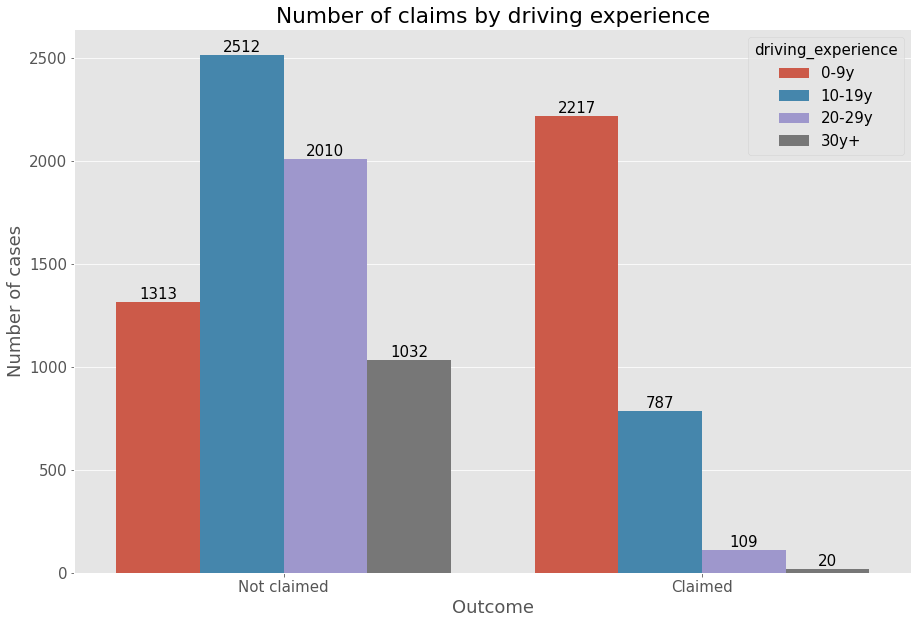

In [67]:
ax = sns.countplot(data=org_data, x='Outcome', hue='driving_experience')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by driving experience')
plt.xlabel('Outcome')
plt.ylabel('Number of cases')

Not only a clear majority of claims (70%) is done by drivers with short experience (<9 years), but also over 60% of all of these drivers made a claim in the last year. This shows, that young drivers (in terms of experience, not age) are more risky for a company and their premium should be higher.

### Model Preprocessing

In [83]:
data = org_data.copy()
# switching label to 1-0 
data['outcome'] = np.where(data['outcome'], 1, 0) 
#dropping unrelevant columns
data = data.drop(['id', 'Outcome'], axis = 1) 

In [51]:
data.head(3)

,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,0,37.454012,1000.000000
1,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,1,95.071431,1333.333333
2,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,0,73.199394,916.666667


<AxesSubplot: >

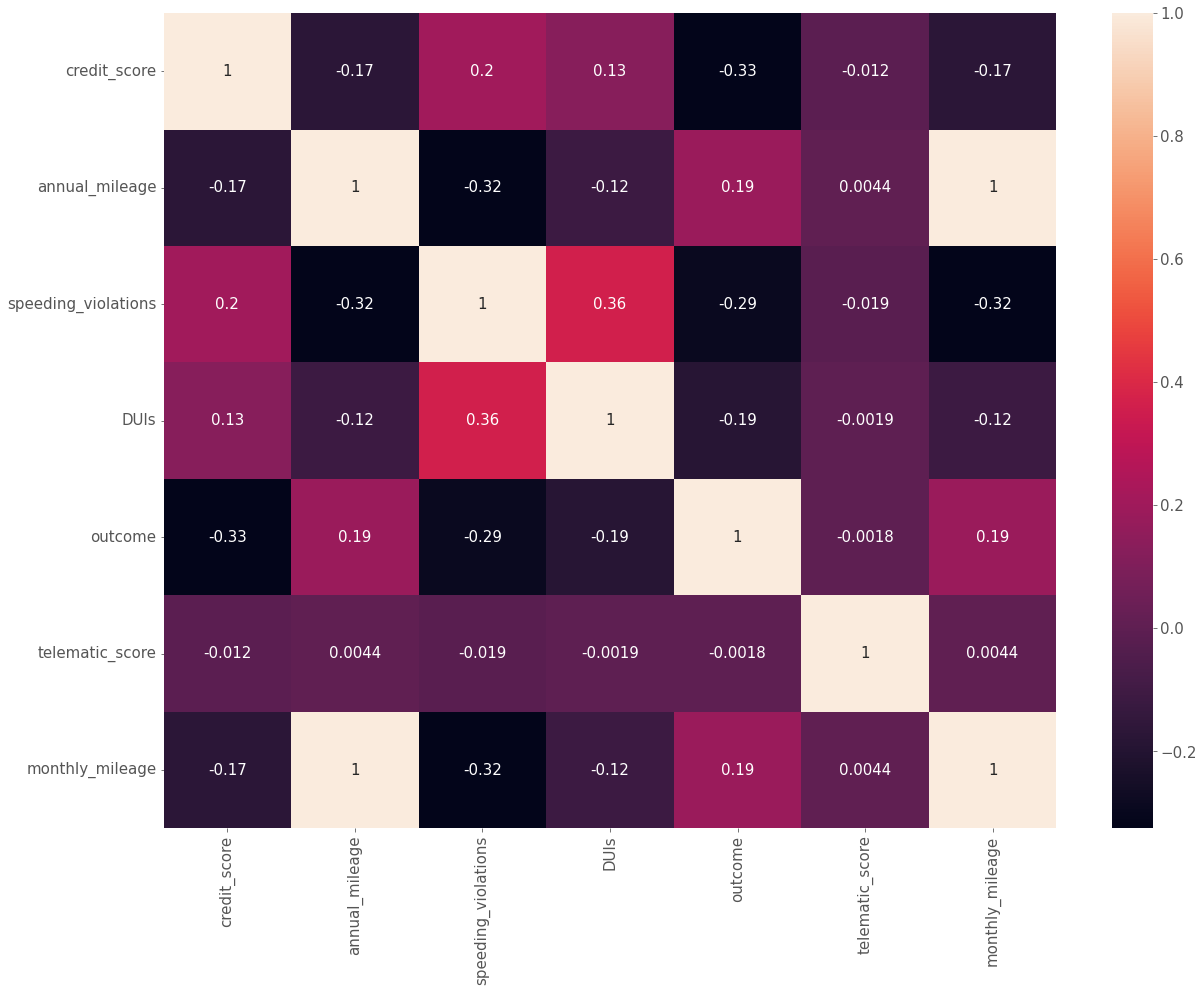

In [84]:
# categorical columns
cat_cols = ['age', 'gender', 'race', 'driving_experience', 'education', 'income', 'vehicle_ownership', 
            'vehicle_year', 'married', 'children', 'postal_code', 'vehicle_type', 'past_accidents']
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams.update({'font.size': 15})
sns.heatmap(data.drop(cat_cols, axis=1).corr(), annot=True)

By looking at the correlation matrix, it can be noticed that some features are moderately correlated. For example, there is a small correlation between speeding violations and DUIs, but also a negative small correlation with monthly mileage. As some features may provide similar information to the models, PCA will be conducted.   

In [57]:
#Nulls 
data.isna().sum()

age                      0
gender                   0
race                     0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
DUIs                     0
past_accidents           0
outcome                  0
telematic_score          0
monthly_mileage        957
dtype: int64

There are three column with missing values in the dataset, with ~1900 unique rows with nulls. There are three ways they can be approached:
- by dropping these rows. By decreasing the amount of available data for modelling, less information can be provided for models, but sometimes it might be the only way;
- by imputing missing values. Imputation allows to find an approximation of the missing observation, which then allows using rows with nulls. This is useful if such row contains valuable information which should be provided into the model, if the missing value is easy to predict or simply if there are many similar rows. However, wrong approach to imputation might highly disrupt final results; 
- by not including columns with missing information in further steps, if a column is proven to be unuseful.

As the goal of this task is to create a PoC and explore if an ML approach makes sense in the first place, the rows with blanks are dropped for now. 

In [85]:
data = data.dropna()

#### Train-test split

In [61]:
data.head()

,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,0,37.454012,1000.000000
1,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,1,95.071431,1333.333333
2,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,0,73.199394,916.666667
3,16-25,male,majority,0-9y,university,low,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,0,59.865848,916.666667
4,26-39,male,majority,10-19y,none,low,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,1,15.601864,1000.000000


In [86]:
y = data['outcome']
X = data.drop('outcome', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

print('Full table:', X.shape, y.shape)
print('Full table: Numer of claims = {}. Number of nonclaims = {}'.format(y[y==1].count(), y[y==0].count()))
print('Training table:', X_train.shape, y_train.shape)
print('Training table: Numer of claims = {}. Number of nonclaims = {}'.format(y_train[y_train==1].count(), y_train[y_train==0].count()))
print('Testing table:', X_test.shape, y_test.shape)
print('Testing table: Numer of claims = {}. Number of nonclaims = {}'.format(y_test[y_test==1].count(), y_test[y_test==0].count()))

Full table: (8149, 19) (8149,)
Full table: Numer of claims = 2536. Number of nonclaims = 5613
Training table: (6519, 19) (6519,)
Training table: Numer of claims = 2029. Number of nonclaims = 4490
Testing table: (1630, 19) (1630,)
Testing table: Numer of claims = 507. Number of nonclaims = 1123


#### Features scaling, OneHot Encoding

In [94]:
# Features scaling
X_train_cat = X_train[cat_cols]
X_train_con = X_train.drop(cat_cols, axis=1)
X_test_cat = X_test[cat_cols]
X_test_con = X_test.drop(cat_cols, axis=1)

# One Hot Encoding - for categorical variables
ohe = OneHotEncoder()
X_train_cat_enc = ohe.fit_transform(X_train_cat)
X_test_cat_enc = ohe.transform(X_test_cat)

# Standard Scaler - for continuous variables
ssc = StandardScaler()
X_train_con_enc = ssc.fit_transform(X_train_con)
X_test_con_enc = ssc.transform(X_test_con)

X_tr = pd.concat([pd.DataFrame(X_train_cat_enc.toarray()), pd.DataFrame(X_train_con_enc)], axis=1)
X_te = pd.concat([pd.DataFrame(X_test_cat_enc.toarray()), pd.DataFrame(X_test_con_enc)], axis=1)
print((X_tr.shape), (X_te.shape))

(6519, 54) (1630, 54)


##### PCA

In [105]:
# Dimensionality reduction
for i in range(1,31):
    pca = PCA(n_components=i)
    X_tr_pca = pca.fit_transform(X_tr)
    X_te_pca = pca.transform(X_te)
    print('Number of components: {}, explained variance: {}'.format(i, np.sum(pca.explained_variance_ratio_)))

Number of components: 1, explained variance: 0.23572310030683824
Number of components: 2, explained variance: 0.35028832652484065
Number of components: 3, explained variance: 0.44033604937300885
Number of components: 4, explained variance: 0.5206445877076951
Number of components: 5, explained variance: 0.5729204701110718
Number of components: 6, explained variance: 0.6163419458507308
Number of components: 7, explained variance: 0.6561346446208282
Number of components: 8, explained variance: 0.6917984320726469
Number of components: 9, explained variance: 0.7224380806891092
Number of components: 10, explained variance: 0.7525977982755522
Number of components: 11, explained variance: 0.7823268694628548
Number of components: 12, explained variance: 0.8108083044580768
Number of components: 13, explained variance: 0.8363813780115196
Number of components: 14, explained variance: 0.8566104149616721
Number of components: 15, explained variance: 0.8745200349192987
Number of components: 16, expla

As checked above, number of components = 21 explains over 95% of variance present in the features. Increase to 99% would require adding 7 (!) more features. As slighlty increased variance would significantly increase the number of features, the chosen number of components is 21. 

In [106]:
pca = PCA(n_components=21)
X_tr_pca = pca.fit_transform(X_tr)
X_te_pca = pca.transform(X_te)

### Modelling

In [110]:
# searching for the best Random Forest parameters
rf_params = {'n_estimators': [int(n) for n in np.linspace(100, 301, 100)],
             'max_features': ['auto', 'log2'],
             'max_depth': [int(n) for n 
                           in np.linspace(5, 51, 10)],
             'min_samples_split': [2, 5, 10, 15],
             'min_samples_leaf': [1, 2, 4], 
             'bootstrap': [True, False]
             }

gs_rf = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                           param_distributions=rf_params,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1,
                           refit=True,
                           n_iter=10)

gs_rf.fit(X_tr_pca, y_train.to_numpy())

for hyperparam in gs_rf.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 1:],": ", gs_rf.best_params_[hyperparam])


n_estimators :  148
min_samples_split :  10
min_samples_leaf :  4
max_features :  log2
max_depth :  40
bootstrap :  True


In [133]:
# Fitting Random Forest
rf_best = RandomForestClassifier(**gs_rf.best_params_, n_jobs=-1, class_weight='balanced')
rf = rf_best.fit(X_tr_pca, y_train.to_numpy())

In [144]:
def con_mat(y_test, y_to_compare, normalize=False):
  from sklearn.metrics import confusion_matrix
  if normalize == True:
    conf_matrix = confusion_matrix(y_test, y_to_compare, normalize='true')
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", annot_kws={"size": 14})
  else:
    conf_matrix = confusion_matrix(y_test, y_to_compare)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d', annot_kws={"size": 14})

  plt.xlabel('Predictions', fontsize=16)
  plt.ylabel('Actuals', fontsize=16)
  plt.title('Confusion Matrix', fontsize=16)

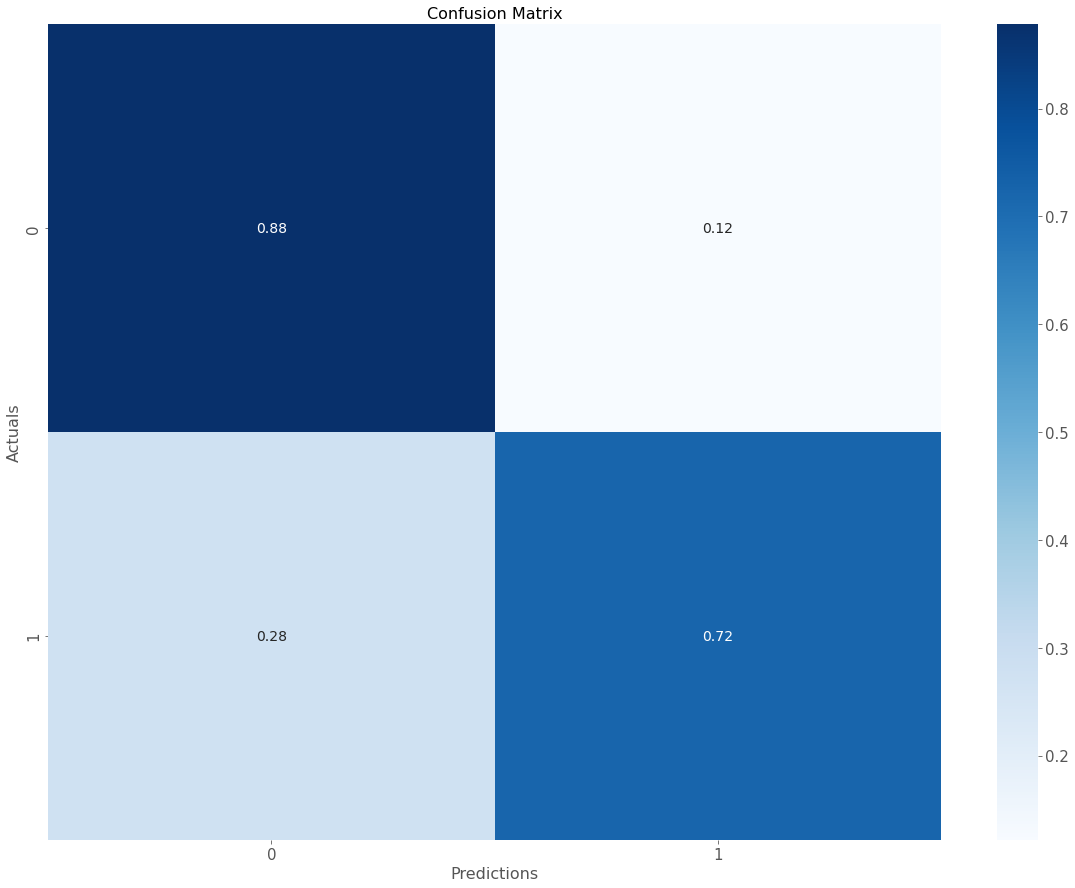

In [145]:
preds = rf.predict_proba(X_te_pca)
cutoff = 0.5
pred = [1 if preds[i][1]>cutoff else 0 for i in range(len(preds))]

con_mat(y_test.to_numpy(), pred, normalize=True)


In [130]:
y_test.dtypes#astype(int)

dtype('int64')

In [135]:
preds

array([[0.71106381, 0.28893619],
       [0.60899207, 0.39100793],
       [0.56687712, 0.43312288],
       ...,
       [0.95609183, 0.04390817],
       [0.57194317, 0.42805683],
       [0.95700227, 0.04299773]])